In [1]:
%cd /home/hotson/kaggle_work/csiro-biomass/scripts

/home/hotson/kaggle_work/csiro-biomass/scripts


# Importing Modules

In [2]:
from models import dinov3_multi_reg, dinov3_multi_reg_structured
from torch.utils.data import dataloader, Dataset
from warnings import filterwarnings
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import albumentations as A
from pathlib import Path
from train import competition_metric
from matplotlib import pyplot as plt
from utils import set_seed, Config as train_config
from PIL import Image
import seaborn as sns
from sklearn.metrics import r2_score
import os

filterwarnings("ignore")

/home/hotson/kaggle_work/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [11]:
class Config:
    model_path: Path = Path("/home/hotson/kaggle_work/csiro-biomass/mlruns/158129828082417321/dc3e7b9da5bb4d218097d994b5527822/artifacts/fold_0_best/DinoV3Structured_fold0.pt")
    device: torch.device = train_config.DEVICE
    model_id: str = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
    patch_size: int = 16
    val_df_path: Path = Path("/home/hotson/kaggle_work/csiro-biomass/exps/splits/csiro_no_folds_75_25_split/val_fold0.csv")
    img_size: int = 512
    img_dir: Path = Path("/home/hotson/kaggle_work/csiro-biomass/train")

set_seed(train_config.SEED)

# Loading Model

In [12]:
model = dinov3_multi_reg_structured.DinoV3Structured(
    dinov3_multi_reg_structured.DinoV3StructuredConfig()
)
ckpt = torch.load(Config.model_path, map_location = Config.device)

state = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state, strict=True)

model.to(Config.device)
model.eval()

print("Loaded model: ", model.__class__.__name__)

Loaded model:  DinoV3Structured


# Loading inference data

In [15]:
class CSIRODataset(Dataset):
    """
    Returns:
      img_t: (3, H, W) where H=2S, W=4S
      y:     (5,) in order:
             [Dry_Green_g, Dry_Dead_g, Dry_Clover_g, GDM_g, Dry_Total_g]
    """
    def __init__(self, df, img_dir, img_size, is_train=True, shadow_p=0.5):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.S = int(img_size)
        self.is_train = is_train

        self.target5_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

        self.H = self.S * 2
        self.W = self.S * 4

        if is_train:
            self.aug = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomShadow(
                        shadow_roi=(0, 0, 1, 1),
                        num_shadows_lower=1,
                        num_shadows_upper=2,
                        shadow_dimension=5,
                        p=shadow_p,
                    ),
                    A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 2.0), p=0.2),
                    # IMPORTANT: keep Resize AFTER geometric transforms
                    A.Resize(self.H, self.W),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    A.pytorch.ToTensorV2(),
                ]
            )
        else:
            self.aug = A.Compose(
                [
                    A.Resize(self.H, self.W),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    A.pytorch.ToTensorV2(),
                ]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        y = torch.tensor(
            row[self.target5_cols].to_numpy(dtype="float32", na_value=0.0),
            dtype=torch.float32,
        )  # (5,)

        img_path = str(row["image_path"])

        with open(img_path, "rb") as f:
            img = np.array(Image.open(f).convert("RGB"))

        img_t = self.aug(image=img)["image"]  # (3,H,W)

        # safety: ensure consistent shape for stacking
        if img_t.shape[-2:] != (self.H, self.W):
            raise RuntimeError(f"Bad shape: {img_t.shape}, expected (3,{self.H},{self.W})")

        image_id = row["image_id"]
        return image_id, img_t, y
    

In [18]:
class CSIRODataset(Dataset):
    """
    Returns:
      img_t: (3, H, W) where H=2S, W=4S
      y:     (5,) in order:
             [Dry_Green_g, Dry_Dead_g, Dry_Clover_g, GDM_g, Dry_Total_g]
    """
    def __init__(self, df, img_dir, img_size, is_train=True, shadow_p=0.5):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.S = int(img_size)
        self.is_train = is_train

        self.target5_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

        self.H = self.S * 2
        self.W = self.S * 4

        if is_train:
            self.aug = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomShadow(
                        shadow_roi=(0, 0, 1, 1),
                        num_shadows_lower=1,
                        num_shadows_upper=2,
                        shadow_dimension=5,
                        p=shadow_p,
                    ),
                    A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 2.0), p=0.2),
                    # IMPORTANT: keep Resize AFTER geometric transforms
                    A.Resize(self.H, self.W),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    A.pytorch.ToTensorV2(),
                ]
            )
        else:
            self.aug = A.Compose(
                [
                    A.Resize(self.H, self.W),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    A.pytorch.ToTensorV2(),
                ]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        y = torch.tensor(
            row[self.target5_cols].to_numpy(dtype="float32", na_value=0.0),
            dtype=torch.float32,
        )  # (5,)

        img_path = "../" + str(row["image_path"])

        with open(img_path, "rb") as f:
            img = np.array(Image.open(f).convert("RGB"))

        img_t = self.aug(image=img)["image"]  # (3,H,W)

        # safety: ensure consistent shape for stacking
        if img_t.shape[-2:] != (self.H, self.W):
            raise RuntimeError(f"Bad shape: {img_t.shape}, expected (3,{self.H},{self.W})")

        image_id = row["image_id"]
        return image_id, img_t, y
    

In [20]:
val_df = pd.read_csv(Config.val_df_path)

val_ds = CSIRODataset(
    val_df,
    img_dir=Config.img_dir,
    img_size=512,
    is_train=False,
    shadow_p=0.0,
)
val_dataloader = dataloader.DataLoader(
    dataset = val_ds,
    batch_size = 4,
    shuffle = False,
    num_workers = 4,
    pin_memory=True,
    drop_last=False
)

all_preds = []
with torch.no_grad():
    pbar = tqdm(val_dataloader, desc="Inference", leave=False, dynamic_ncols=True)
    for img_ids, img_full_t, y in pbar:
        img_full_t = img_full_t.to(Config.device, non_blocking=True)

        preds = model(img_full_t)

        for img_id, pred in zip(img_ids, preds["pred5"].cpu().numpy()):
            all_preds.append({
                "image_id": img_id,
                "Dry_Green_g": pred[0],
                "Dry_Dead_g": pred[1],
                "Dry_Clover_g": pred[2],
                "GDM_g": pred[3],
                "Dry_Total_g": pred[4],
            })

preds_df = pd.DataFrame(all_preds)
preds_df

,image_id,Dry_Green_g,Dry_Dead_g,Dry_Clover_g,GDM_g,Dry_Total_g
0,ID1025234388,6.466345,3.822591,4.843655,12.679433,16.502024
1,ID1051144034,29.797188,5.284720,47.267681,52.163029,57.447750
2,ID1108283583,19.131147,9.008807,8.568876,30.827457,39.836266
3,ID1113329413,19.169613,5.995848,28.515223,37.037354,43.033203
4,ID112966473,10.738261,6.079415,7.299924,19.563242,25.642656
...,...,...,...,...,...,...
61,ID7850481,9.212154,3.783547,15.324383,21.270844,25.054390
62,ID797502182,9.494757,7.071981,1.155692,11.885288,18.957270
63,ID799079114,14.024364,10.854178,1.087353,16.144848,26.999025
64,ID875119737,12.381947,8.600485,3.927550,18.789795,27.390280


# Model Performance

In [21]:
merged_df = val_df.merge(
    preds_df,
    on = "image_id",
    how = "inner",
    suffixes=("_gt", "_pred")
)
merged_df

,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g_gt,Dry_Dead_g_gt,Dry_Green_g_gt,Dry_Total_g_gt,GDM_g_gt,env_group,strata,fold,Dry_Green_g_pred,Dry_Dead_g_pred,Dry_Clover_g_pred,GDM_g_pred,Dry_Total_g_pred
0,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0,6.0500,0.0000,0.0000,6.0500,6.0500,WA_2015/9/1,0,0,6.466345,3.822591,4.843655,12.679433,16.502024
1,ID1051144034,train/ID1051144034.jpg,2015/9/1,WA,SubcloverLosa,0.80,1.0,55.3200,0.0000,0.0000,55.3200,55.3200,WA_2015/9/1,40,0,29.797188,5.284720,47.267681,52.163029,57.447750
2,ID1108283583,train/ID1108283583.jpg,2015/8/19,Vic,Phalaris_Ryegrass_Clover,0.83,5.5,5.7730,7.2162,40.4108,53.4000,46.1838,Vic_2015/8/19,42,0,19.131147,9.008807,8.568876,30.827457,39.836266
3,ID1113329413,train/ID1113329413.jpg,2015/6/29,Tas,WhiteClover,0.72,3.0,20.6523,21.1112,1.3768,43.1403,22.0291,Tas_2015/6/29,30,0,19.169613,5.995848,28.515223,37.037354,43.033203
4,ID112966473,train/ID112966473.jpg,2015/8/14,Vic,Ryegrass_Clover,0.74,3.0,11.2000,2.8000,19.6000,33.6000,30.8000,Vic_2015/8/14,21,0,10.738261,6.079415,7.299924,19.563242,25.642656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,ID7850481,train/ID7850481.jpg,2015/9/1,WA,SubcloverLosa,0.69,1.0,19.5700,0.0000,0.0000,19.5700,19.5700,WA_2015/9/1,0,0,9.212154,3.783547,15.324383,21.270844,25.054390
62,ID797502182,train/ID797502182.jpg,2015/7/1,Tas,Ryegrass,0.43,3.0,0.0000,12.6079,6.9746,19.5825,6.9746,Tas_2015/7/1,1,0,9.494757,7.071981,1.155692,11.885288,18.957270
63,ID799079114,train/ID799079114.jpg,2015/7/1,Tas,Ryegrass,0.53,4.0,0.0000,19.7501,8.0022,27.7523,8.0022,Tas_2015/7/1,10,0,14.024364,10.854178,1.087353,16.144848,26.999025
64,ID875119737,train/ID875119737.jpg,2015/8/14,Vic,Ryegrass_Clover,0.72,4.0,5.8000,5.8000,23.2000,34.8000,29.0000,Vic_2015/8/14,22,0,12.381947,8.600485,3.927550,18.789795,27.390280


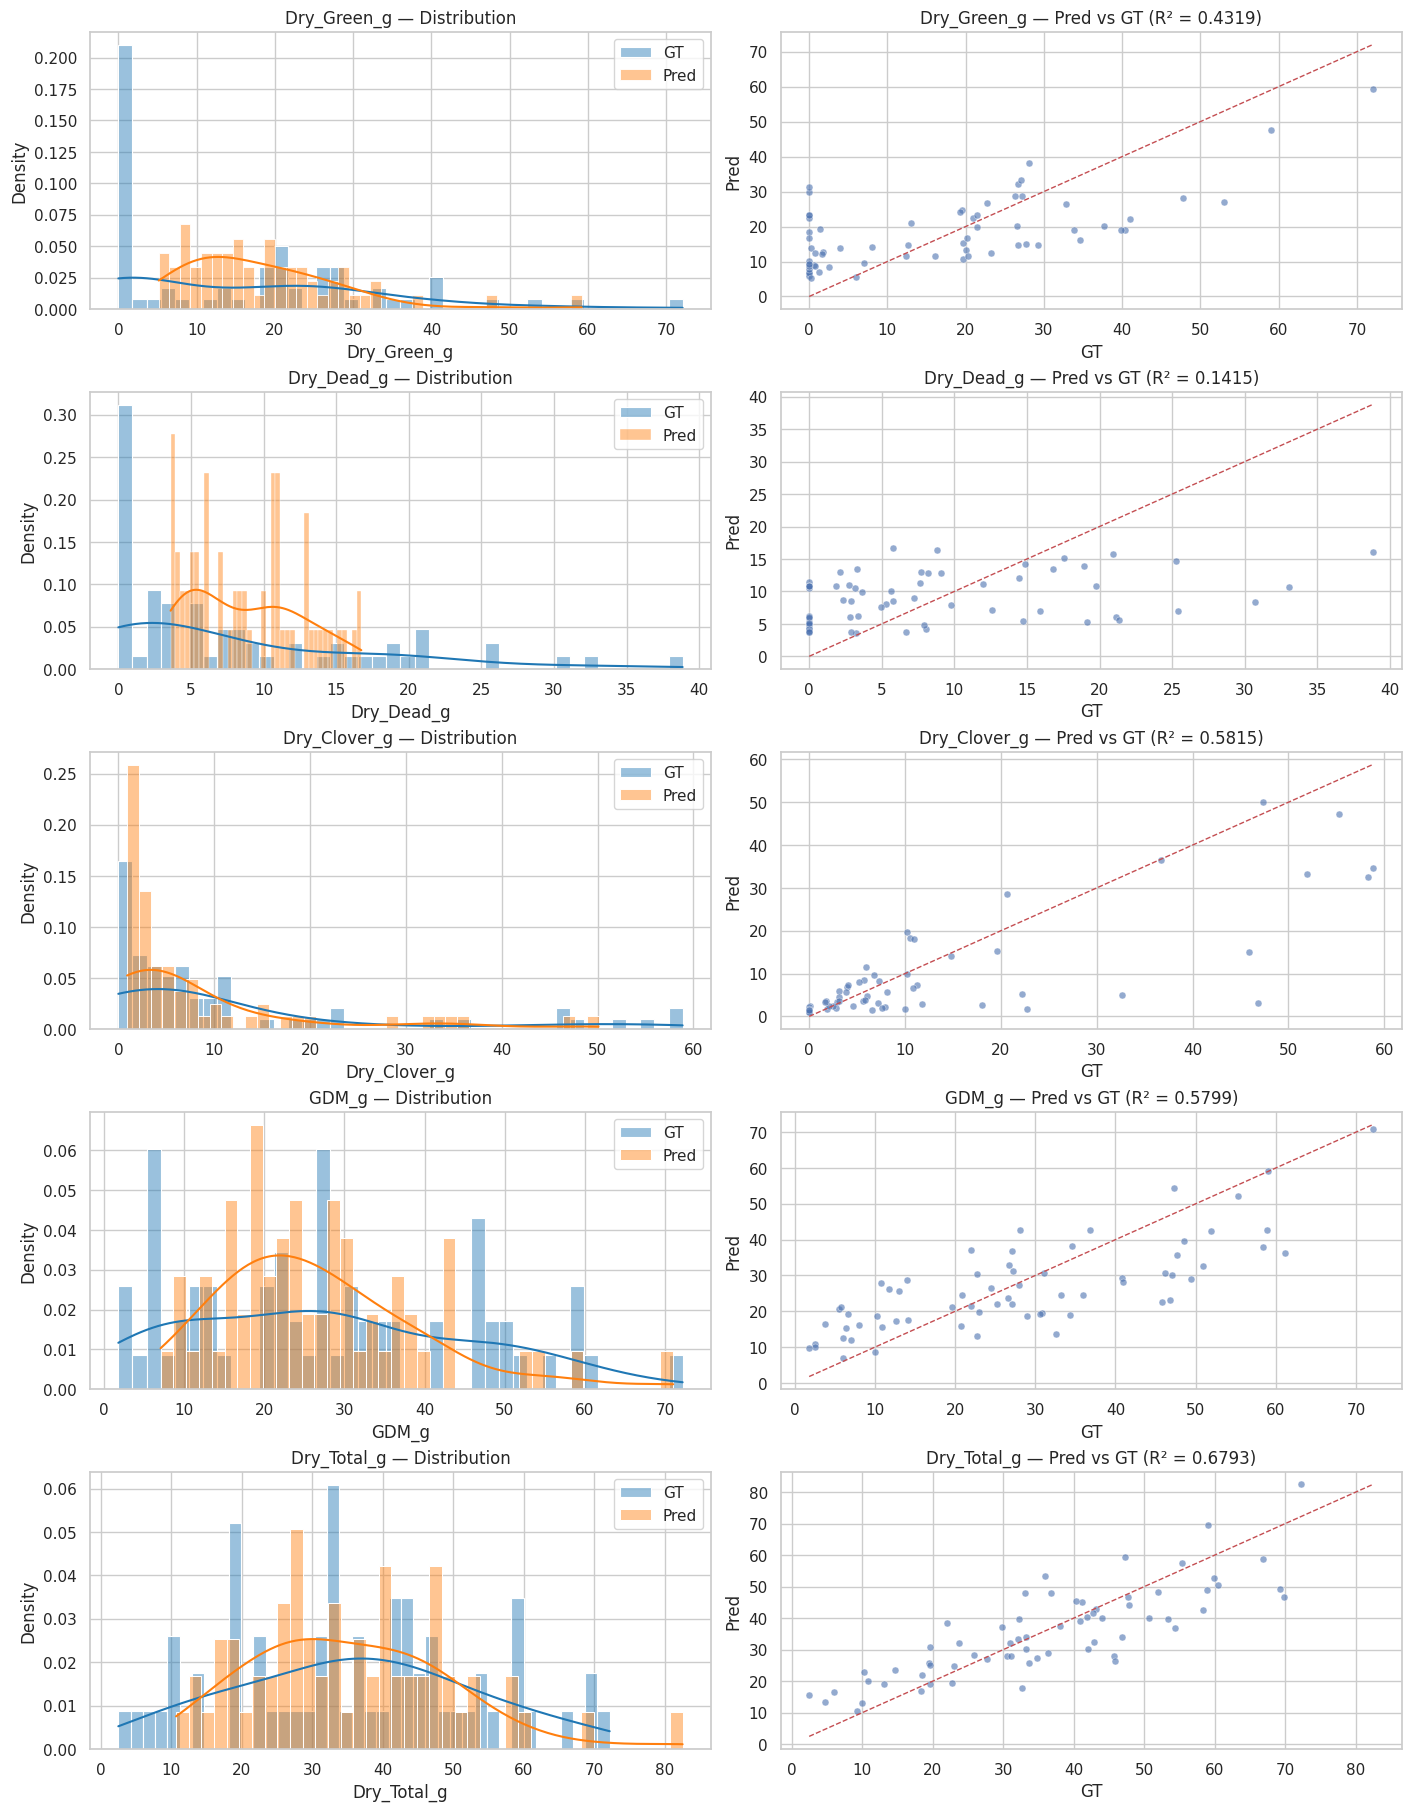

In [22]:
sns.set_theme(style="whitegrid")  # optional
targets = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]
fig, axes = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=(14, 18),
    constrained_layout=True
)

for i, t in enumerate(targets):
    gt = merged_df[f"{t}_gt"].astype(float).to_numpy()
    pred = merged_df[f"{t}_pred"].astype(float).to_numpy()

    # -----------------------------
    # Left: Histogram (GT vs Pred)
    # -----------------------------
    ax_hist = axes[i, 0]
    sns.histplot(gt, bins=40, stat="density", kde=True,
                 color="tab:blue", alpha=0.45, label="GT", ax=ax_hist)
    sns.histplot(pred, bins=40, stat="density", kde=True,
                 color="tab:orange", alpha=0.45, label="Pred", ax=ax_hist)

    ax_hist.set_title(f"{t} — Distribution")
    ax_hist.set_xlabel(t)
    ax_hist.set_ylabel("Density")
    ax_hist.legend()

    # -----------------------------
    # Right: Scatter + R²
    # -----------------------------
    ax_scatter = axes[i, 1]
    r2 = r2_score(gt, pred)

    sns.scatterplot(x=gt, y=pred, s=25, alpha=0.6, ax=ax_scatter)

    mn = min(gt.min(), pred.min())
    mx = max(gt.max(), pred.max())
    ax_scatter.plot([mn, mx], [mn, mx], "r--", linewidth=1)

    ax_scatter.set_title(f"{t} — Pred vs GT (R² = {r2:.4f})")
    ax_scatter.set_xlabel("GT")
    ax_scatter.set_ylabel("Pred")

plt.show()
